In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Download the data
import pandas_datareader as pdr

ewa = pdr.get_data_yahoo('EWA', start='2011-01-01', end='2019-12-23')['Adj Close']
ewc = pdr.get_data_yahoo('EWC', start='2011-01-01', end='2019-12-23')['Adj Close']

In [3]:
# The Hedge ratio calculated as in the video
beta = 0.92

In [4]:
# Get the spread data
spread = pd.read_csv('spread.csv', index_col=0)['Adj Close']
spread.index = pd.to_datetime(spread.index)

## Ex 6.1

In the lecture, we set our trading signal, i.e., the threshold, to be $$0.5*std_{spread}$$ 

What if we increase this threshold to be $$1*std_{spread}$$

How would it affect our P&L curve?

### Solution

In [5]:
# Solution

thresh = np.std(spread)*1

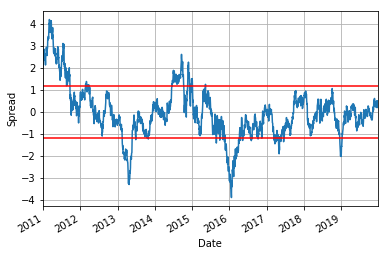

In [6]:
spread.plot()
plt.axhline(y = thresh, color='r')
plt.axhline(y = -thresh, color='r')
plt.ylabel('Spread')
plt.grid()
plt.show()

__The backtest__

In [7]:
# This indicates whether we have a position on or not
inpos = 0

# This is the PnL per trade
pnl = []

# A list to save what position we have each day
pos = []

time_in_trade = []
exit_date = []

for date in spread.index:
    
    if spread[date] > thresh and not inpos:
        '''Entry Short Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = -1
        
    elif spread[date] < 0 and inpos == -1:
        '''Exit Short Spread'''
        p =  entry_price - spread[date]
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit short:',sum(pnl))
        
    elif spread[date] < -thresh and not inpos:
        '''Entry Long Spread'''
        entry_price = spread[date]
        open_time = date
        inpos = 1
        
    elif spread[date] > 0 and inpos == 1:
        '''Exit Long Spread'''
        p = spread[date] - entry_price
        pnl.append(p)
        inpos = 0
        time_in_trade.append((date-open_time).days)
        exit_date.append(date)
        print('Exit long:',sum(pnl))  
        
    pos.append(inpos)

Exit short: 2.1916657021641957
Exit short: 3.5089694764486055
Exit long: 4.752692595511295
Exit long: 6.0124439114893775
Exit short: 7.32826314826157
Exit short: 8.690538144277632
Exit short: 10.029987696805215
Exit long: 11.480528652060098
Exit long: 12.7513314392421
Exit long: 14.250951170047674


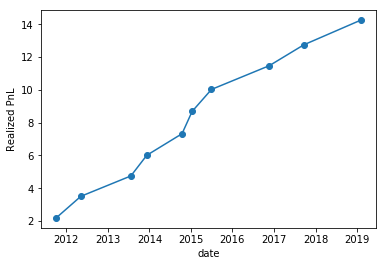

In [8]:
s_pnl = pd.Series(pnl)
s_pnl.index = exit_date

plt.plot(np.cumsum(s_pnl),'-o')
plt.xlabel('date')
plt.ylabel('Realized PnL')
plt.show()

We see that the realised P&L is less than before. This shows that having a wider threshold will result in less frequent trades, yet the profit per trade did not catch up, resulting in a smaller cumulative P&L at the end. 

Now we have seen that different threshold levels will affect how our trading strategy performs.  

## Ex 6.2
We will incorporate the trading cost now into our backtest. This will again affect the performance of our trading strategy. 

Assume our commision is 5 basis points. What would the optimum threshold be (i.e., to maximise our cumulative realised P&L)?

__Hint:__

The trading cost can be calculated as $$T = (ewc + beta*ewa)*c,$$
where c is the commision. 

Then the profit per trade can be calculated using $$(spread_{t+1} - spread_{t}) - (T_{t+1} + T_{t}).$$

### Solution

In [9]:
def backtest(bw, comm):
    """bw is the variable for defining the trading threshold, comm is the commission."""
    tc = (ewc + beta*ewa)*comm
  
  # The trading signal
    thresh = np.std(spread)*bw

  # This indicates whether we have a position on or not
    inpos = 0

  # This is the PnL per trade
    pnl = []

    # A list to save what position we have each day
    pos = []

    time_in_trade = []
    exit_date = []
    for date in spread.index:

        if spread[date] > thresh and not inpos:
            '''Entry Short Spread'''
            entry_price = spread[date]
            open_time = date
            inpos = -1

            # Both prices need to be taken positive no matter if long or short
            entry_cost = tc[date]

        elif spread[date] < 0 and inpos == -1:
            '''Exit Short Spread'''
            p =  entry_price - spread[date] - (tc[date]+entry_cost)
            pnl.append(p)
            inpos = 0
            time_in_trade.append((date-open_time).days)
            exit_date.append(date)
              
        elif spread[date] < -thresh and not inpos:
            '''Entry Long Spread'''
            entry_price = spread[date]
            open_time = date
            inpos = 1
            entry_cost = tc[date]

        elif spread[date] > 0 and inpos == 1:
            '''Exit Long Spread'''
            p = spread[date] - entry_price - (tc[date]+entry_cost)
            pnl.append(p)
            inpos = 0
            time_in_trade.append((date-open_time).days)
            exit_date.append(date)

        pos.append(inpos)
    return sum(pnl)

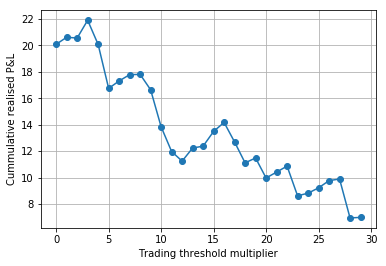

In [10]:
profit = []

# Commission
c = 0.0005

for i in range(30):
    profit.append(backtest(i*0.1, c))

plt.plot(profit, 'o-')
plt.xlabel('Trading threshold multiplier')
plt.ylabel('Cummulative realised P&L')
plt.grid()    

__Comments__

As we can see from the graph above, the cummulative realised P&L is affected by the trading threshold multiplier(note the exact threshold is defined in the backtest function). The optimum trading threshold multiplier seems to be 3, and the exact threshold is $$std(spread)*0.3.$$

It seems that our strategy works best for smaller and more frequent trades, considering the commission rate being 5 basis points. 

## Bonus section

What happens if our commission rate is different, i.e., 10 basis points, 15 basis points, etc.? How does it affect our P&L?

### Solution

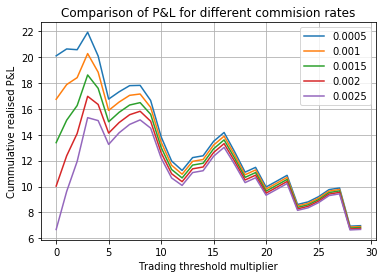

In [11]:
basis_pts = [0.0005, 0.001, 0.0015, 0.002, 0.0025]

for n in basis_pts:
    profit = []
    for i in range(30):
        profit.append(backtest(i*0.1, n))
    plt.plot(profit, label=n)

plt.legend()
plt.xlabel('Trading threshold multiplier')
plt.ylabel('Cummulative realised P&L')
plt.title('Comparison of P&L for different commision rates')
plt.grid()
plt.show()

__Comments__

The different commission rates did have a significant impact on the performance of our strategy! It is interesting to note that the various curves all follow the same trend: 
* The P&L is maximised by having a small trading threshold, i.e., trades are more frequent but each having small consistent gains. 
* As the trading threshold increases, the P&L tends to decrease in a broad sense, but with ups and downs in between. This is the effect of two opposit forces in play. 